In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 1. 필터 함수 정의 및 데이터 불러오기
from scipy.signal import savgol_filter, butter, filtfilt, medfilt, gaussian

# 데이터 불러오기
fd001 = pd.read_csv('../CMaps/Data/train_FD001_with_RUL.csv')
fd004 = pd.read_csv('../CMaps/Data/train_FD004_with_RUL.csv')

# Sensor 2 추출
sensor_col = 'T24' if 'T24' in fd001.columns else fd001.columns[2]
s2_fd001 = fd001[sensor_col].values
s2_fd004 = fd004[sensor_col].values


In [3]:

# 필터 적용 함수들
def moving_average(x, w=5):
    return np.convolve(x, np.ones(w)/w, mode='same')
def apply_savgol(x, window=11, poly=2):
    return savgol_filter(x, window_length=window, polyorder=poly)
def apply_butterworth(x, order=3, cutoff=0.1):
    b, a = butter(order, cutoff)
    return filtfilt(b, a, x)
def apply_median(x, kernel=5):
    return medfilt(x, kernel_size=kernel)
def apply_gaussian(x, std=2, window=11):
    g = gaussian(window, std)
    g /= g.sum()
    return np.convolve(x, g, mode='same')

filters = {
    'Original': lambda x: x,
    'MovingAvg': moving_average,
    'Savgol': apply_savgol,
    'Butterworth': apply_butterworth,
    'Median': apply_median,
    'Gaussian': apply_gaussian
}


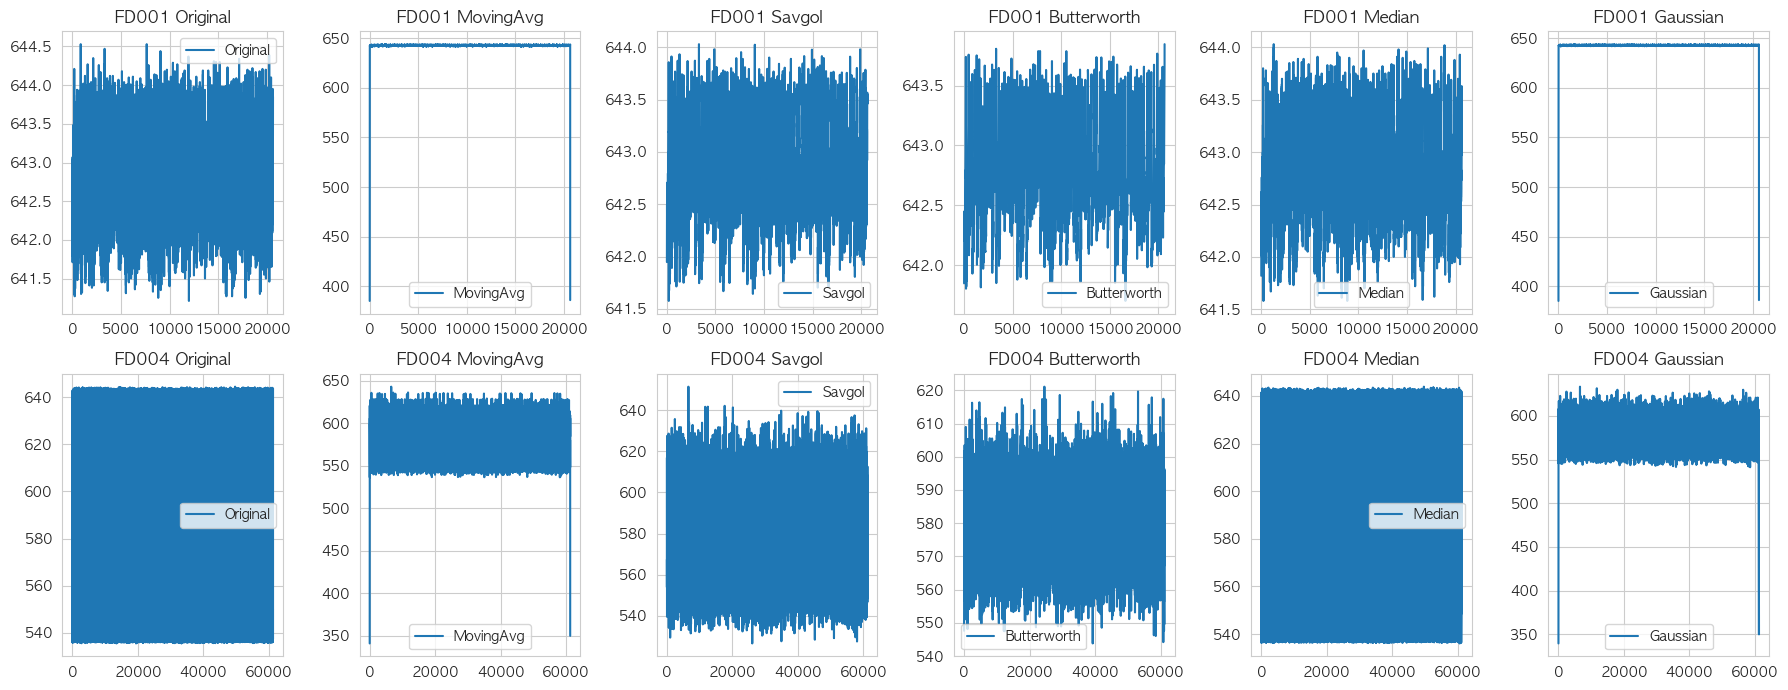

In [4]:

# 2. Sensor 2 필터링 비교 subplot
fig, axes = plt.subplots(2, len(filters), figsize=(18, 7))
for i, (name, func) in enumerate(filters.items()):
    axes[0, i].plot(func(s2_fd001), label=name)
    axes[0, i].set_title(f'FD001 {name}')
    axes[1, i].plot(func(s2_fd004), label=name)
    axes[1, i].set_title(f'FD004 {name}')
    axes[0, i].legend()
    axes[1, i].legend()
plt.tight_layout()
plt.show()


In [5]:

# 3. Delay zone 계산 함수 (예시: 변화량이 일정 threshold 이하인 구간)
def calc_delay_zone(x, threshold=0.01):
    dx = np.abs(np.diff(x))
    delay = np.sum(dx < threshold)
    return delay


In [6]:

# FD001/FD004 delay zone 계산
fd001_delay = {name: calc_delay_zone(func(s2_fd001)) for name, func in filters.items()}
fd004_delay = {name: calc_delay_zone(func(s2_fd004)) for name, func in filters.items()}


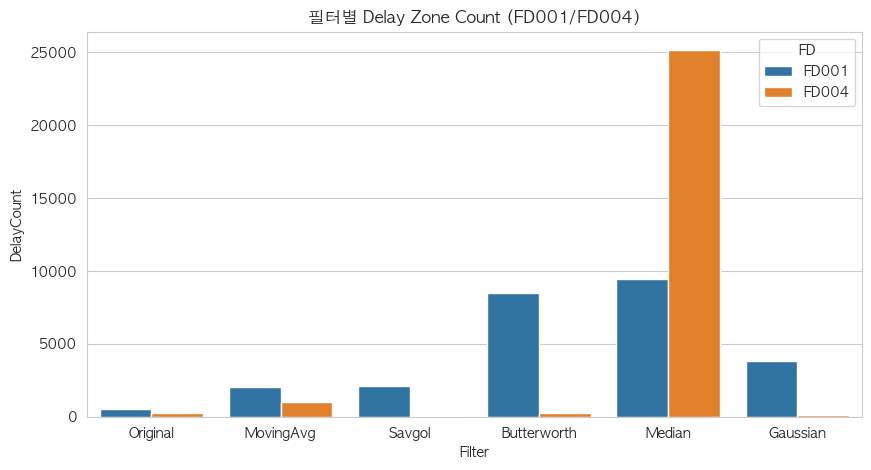

In [7]:

# 4. delay count barplot
delay_df = pd.DataFrame({'FD001': fd001_delay, 'FD004': fd004_delay})
delay_df = delay_df.reset_index().rename(columns={'index': 'Filter'})
delay_df_melt = delay_df.melt(id_vars='Filter', value_vars=['FD001', 'FD004'], var_name='FD', value_name='DelayCount')
plt.figure(figsize=(10,5))
sns.barplot(x='Filter', y='DelayCount', hue='FD', data=delay_df_melt)
plt.title('필터별 Delay Zone Count (FD001/FD004)')
plt.show()

In [10]:
# 5. 필터별 LinearRegression 모델 저장 예시
from sklearn.linear_model import LinearRegression
import joblib
import os

os.makedirs('../models', exist_ok=True)

# Sensor 2 필터링 데이터로만 예시 (실제 feature 전체 사용 시 get_feature_target 활용)
for name, func in filters.items():
    X_train = func(s2_fd001).reshape(-1, 1)
    y_train = fd001['RUL'].values
    model = LinearRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, f"../models/linear_regression_fd001_{name.lower()}.pkl")
    print(f"저장 완료: ../models/linear_regression_fd001_{name.lower()}.pkl")

저장 완료: ../models/linear_regression_fd001_original.pkl
저장 완료: ../models/linear_regression_fd001_movingavg.pkl
저장 완료: ../models/linear_regression_fd001_savgol.pkl
저장 완료: ../models/linear_regression_fd001_butterworth.pkl
저장 완료: ../models/linear_regression_fd001_median.pkl
저장 완료: ../models/linear_regression_fd001_gaussian.pkl
